In [1]:
from skopt.space import Real, Integer, Categorical
import numpy as np
import torch
import torch.nn as nn
import torchbnn as bnn  # torchbnn library for BNN layers
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from tqdm import tqdm

In [ ]:

class BayesianNN(nn.Module):
    def __init__(self, input_dim, prior_mu, prior_sigma, layer1_units, layer2_units):
        super(BayesianNN, self).__init__()
        # Define prior parameters
        
        # Initialize Bayesian layers with the specified priors
        self.fc1 = bnn.BayesLinear(prior_mu, prior_sigma, in_features=input_dim, out_features=layer1_units)
        self.fc2 = bnn.BayesLinear(prior_mu, prior_sigma, in_features=layer1_units, out_features=layer2_units)
        self.fc3 = bnn.BayesLinear(prior_mu, prior_sigma, in_features=layer2_units, out_features=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [3]:
def train_bayesian_nn(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)  # Shape: (batch_size, 1)
        
        # Ensure y_batch has the same shape as y_pred
        y_batch = y_batch.unsqueeze(1)  # Convert y_batch shape to (batch_size, 1) if needed
        
        loss = criterion(y_pred, y_batch)  # Now both are of shape (batch_size, 1)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [4]:

#     return np.array(all_preds)
def evaluate_bayesian_nn(model, val_loader):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)

            # Round predictions and move to CPU for compatibility
            y_pred = y_pred.round().cpu().numpy()

            # If y_pred is a scalar, wrap it in a list, otherwise ensure it's a list-like object
            if np.isscalar(y_pred):
                y_pred = [y_pred]  # Wrap scalar in a list
            elif len(y_pred.shape) == 1:  # If it's already a 1D array, no need to squeeze
                y_pred = y_pred.tolist()  # Convert it to a list directly

            # Extend the list of predictions
            all_preds.extend(y_pred)

    return np.array(all_preds)

def evaluate_bayesian_nn2(model, loader, n_samples=50):
    model.eval()
    all_preds = []
    all_uncertainties = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            preds = []
            for _ in range(n_samples):
                y_pred = model(X_batch)
                preds.append(y_pred.squeeze().cpu().numpy())
            preds = np.array(preds)  # Shape: (n_samples, batch_size)
            mean_preds = preds.mean(axis=0)
            std_preds = preds.std(axis=0)
            all_preds.extend(mean_preds)
            all_uncertainties.extend(std_preds)
            all_labels.extend(y_batch.cpu().numpy())
    return np.array(all_preds), np.array(all_uncertainties), np.array(all_labels)



In [5]:
# Calibration plot
def plot_reliability_diagram(y_preds, y_true, bins=10):
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_indices = np.digitize(y_preds, bin_edges, right=True) - 1

    accuracies = []
    confidences = []
    for i in range(bins):
        bin_mask = bin_indices == i
        if np.any(bin_mask):
            accuracies.append(y_true[bin_mask].mean())
            confidences.append(y_preds[bin_mask].mean())
        else:
            accuracies.append(0)
            confidences.append(0)

    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
    plt.plot(confidences, accuracies, marker="o", label="Model Calibration")
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid()
    plt.show()


In [6]:
def plot_uncertainty(y_preds, uncertainties):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_preds, uncertainties, alpha=0.5, edgecolor="k", label="Predictions")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Uncertainty (Std Dev)")
    plt.title("Uncertainty vs Prediction")
    plt.legend()
    plt.grid()
    plt.show()


In [8]:
# Function to run BNN for each value of n
def run_bayesian_nn(n, hyper_params):
    # Load data
    X = np.load(f'Datasets/kryptonite-{n}-X.npy')
    y = np.load(f'Datasets/kryptonite-{n}-y.npy')
    
    # Split data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Convert data to PyTorch tensors and create DataLoaders
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32).clone().detach(), torch.tensor(y_train, dtype=torch.float32).clone().detach()
    X_val, y_val = torch.tensor(X_val, dtype=torch.float32).clone().detach(), torch.tensor(y_val, dtype=torch.float32).clone().detach()
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32).clone().detach(), torch.tensor(y_test, dtype=torch.float32).clone().detach()
    
    # Convert data to PyTorch tensors and create DataLoaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=hyper_params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=hyper_params['batch_size'])
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

    # Initialize the model, loss function, and optimizer
    input_dim = X_train.shape[1]
    model = BayesianNN(input_dim=input_dim, prior_mu=hyper_params['prior_mu'], prior_sigma=hyper_params['prior_sigma'], layer1_units=hyper_params['layer1_units'], layer2_units=hyper_params['layer2_units'])

    
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
    # optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning_rate'])
    optimizer = torch.optim.RAdam(model.parameters(), lr=hyper_params['learning_rate'])
    
    # Train the model and track training loss
    training_losses = []
    for epoch in range(hyper_params['epochs']):
        train_loss = train_bayesian_nn(model, train_loader, criterion, optimizer)
        training_losses.append(train_loss)
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")
    
    # Validate the model
    y_val_pred = evaluate_bayesian_nn(model, val_loader)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy for n={n}: {val_accuracy:.4f}")
    
    # Test the model
    y_test_pred = evaluate_bayesian_nn(model, test_loader)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy for n={n}: {test_accuracy:.4f}")
    
    return test_accuracy

In [7]:
def run_bayesian_nn_plot(n, hyper_params, n_samples=50):
    # Load data
    X = np.load(f'Datasets/kryptonite-{n}-X.npy')
    y = np.load(f'Datasets/kryptonite-{n}-y.npy')

    # Split data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Convert data to PyTorch tensors and create DataLoaders
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=hyper_params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=hyper_params['batch_size'])
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

    # Initialize the model
    input_dim = X_train.shape[1]
    model = BayesianNN(
        input_dim=input_dim,
        prior_mu=hyper_params['prior_mu'],
        prior_sigma=hyper_params['prior_sigma'],
        layer1_units=hyper_params['layer1_units'],
        layer2_units=hyper_params['layer2_units'],
    )

    criterion = nn.BCELoss()
    optimizer = torch.optim.RAdam(model.parameters(), lr=hyper_params['learning_rate'])

    # Train the model
    training_losses = []
    for epoch in range(hyper_params['epochs']):
        train_loss = train_bayesian_nn(model, train_loader, criterion, optimizer)
        training_losses.append(train_loss)
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")

    # Validate the model
    y_val_pred, y_val_uncertainty, y_val_true = evaluate_bayesian_nn2(model, val_loader, n_samples=n_samples)
    val_accuracy = accuracy_score((y_val_pred > 0.5).astype(int), y_val_true)
    print(f"Validation Accuracy for n={n}: {val_accuracy:.4f}")

    # Test the model
    y_test_pred, y_test_uncertainty, y_test_true = evaluate_bayesian_nn2(model, test_loader, n_samples=n_samples)
    test_accuracy = accuracy_score((y_test_pred > 0.5).astype(int), y_test_true)
    print(f"Test Accuracy for n={n}: {test_accuracy:.4f}")

    # Visualisations
    print("Plotting Reliability Diagram...")
    plot_reliability_diagram(y_val_pred, y_val_true)

    print("Plotting Uncertainty...")
    plot_uncertainty(y_val_pred, y_val_uncertainty)

    return test_accuracy


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.7047
Epoch 2, Train Loss: 0.7032
Epoch 3, Train Loss: 0.7024
Epoch 4, Train Loss: 0.7016
Epoch 5, Train Loss: 0.6974
Epoch 6, Train Loss: 0.6956
Epoch 7, Train Loss: 0.6970
Epoch 8, Train Loss: 0.6947
Epoch 9, Train Loss: 0.6949
Epoch 10, Train Loss: 0.6938
Epoch 11, Train Loss: 0.6947
Epoch 12, Train Loss: 0.6936
Epoch 13, Train Loss: 0.6945
Epoch 14, Train Loss: 0.6934
Epoch 15, Train Loss: 0.6935
Epoch 16, Train Loss: 0.6929
Epoch 17, Train Loss: 0.6928
Epoch 18, Train Loss: 0.6927
Epoch 19, Train Loss: 0.6894
Epoch 20, Train Loss: 0.6847
Epoch 21, Train Loss: 0.6752
Epoch 22, Train Loss: 0.6595
Epoch 23, Train Loss: 0.6257
Epoch 24, Train Loss: 0.5787
Epoch 25, Train Loss: 0.5063
Epoch 26, Train Loss: 0.4482
Epoch 27, Train Loss: 0.3846
Epoch 28, Train Loss: 0.3423
Epoch 29, Train Loss: 0.3383
Epoch 30, Train Loss: 0.2970
Epoch 31, Train Loss: 0.2720
Epoch 32, Train Loss: 0.2642
Epoch 33, Train Loss: 0.2567
Epoch 34, Train Loss: 0.2400
Epoch 35, Train Loss: 0

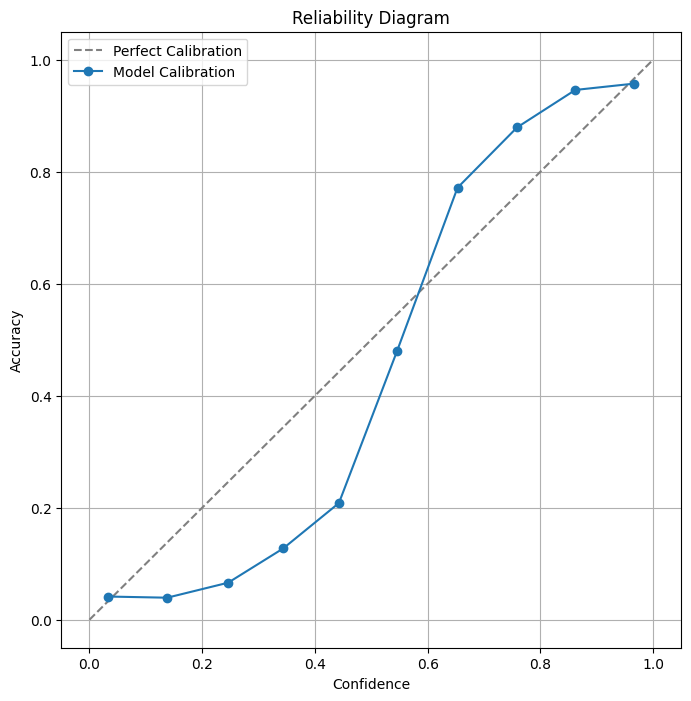

Plotting Uncertainty...


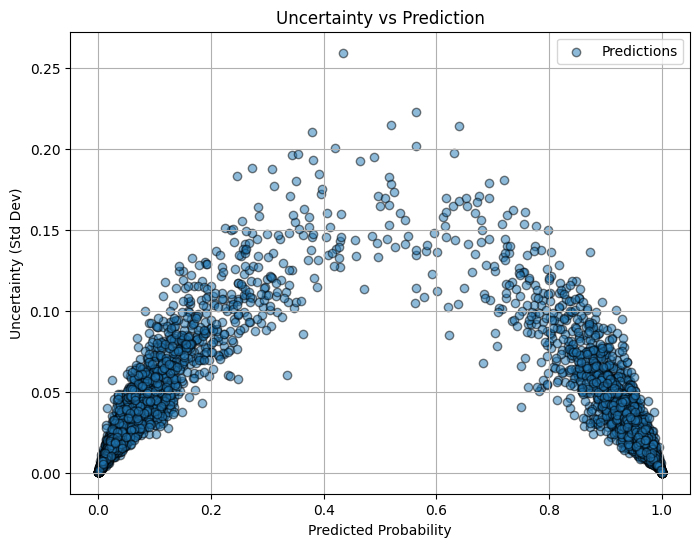

 33%|███▎      | 1/3 [00:12<00:25, 12.72s/it]

Epoch 1, Train Loss: 0.6993
Epoch 2, Train Loss: 0.6972
Epoch 3, Train Loss: 0.6959
Epoch 4, Train Loss: 0.6952
Epoch 5, Train Loss: 0.6955
Epoch 6, Train Loss: 0.6963
Epoch 7, Train Loss: 0.6950
Epoch 8, Train Loss: 0.6955
Epoch 9, Train Loss: 0.6939
Epoch 10, Train Loss: 0.6947
Epoch 11, Train Loss: 0.6946
Epoch 12, Train Loss: 0.6947
Epoch 13, Train Loss: 0.6936
Epoch 14, Train Loss: 0.6947
Epoch 15, Train Loss: 0.6944
Epoch 16, Train Loss: 0.6938
Epoch 17, Train Loss: 0.6935
Epoch 18, Train Loss: 0.6932
Epoch 19, Train Loss: 0.6936
Epoch 20, Train Loss: 0.6928
Epoch 21, Train Loss: 0.6933
Epoch 22, Train Loss: 0.6938
Epoch 23, Train Loss: 0.6930
Epoch 24, Train Loss: 0.6930
Epoch 25, Train Loss: 0.6929
Epoch 26, Train Loss: 0.6932
Epoch 27, Train Loss: 0.6928
Epoch 28, Train Loss: 0.6930
Epoch 29, Train Loss: 0.6929
Epoch 30, Train Loss: 0.6925
Epoch 31, Train Loss: 0.6924
Epoch 32, Train Loss: 0.6930
Epoch 33, Train Loss: 0.6926
Epoch 34, Train Loss: 0.6918
Epoch 35, Train Loss: 0

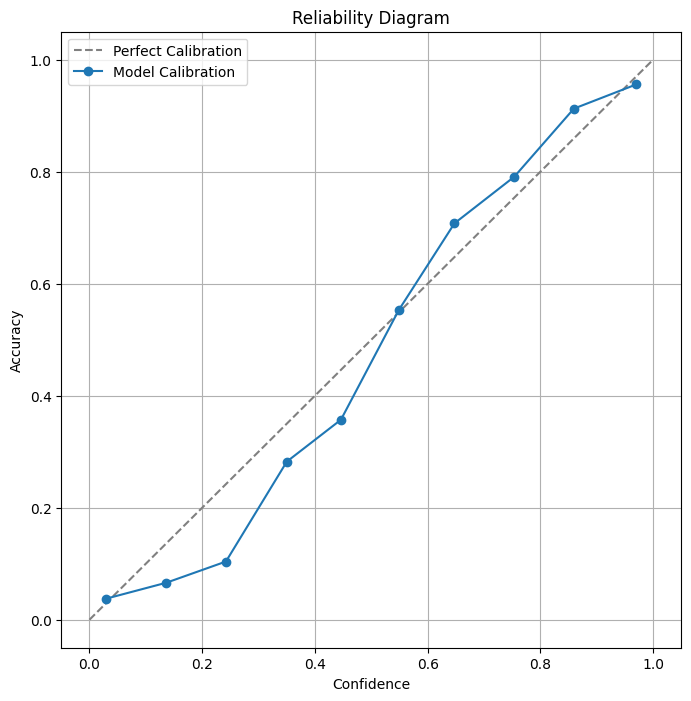

Plotting Uncertainty...


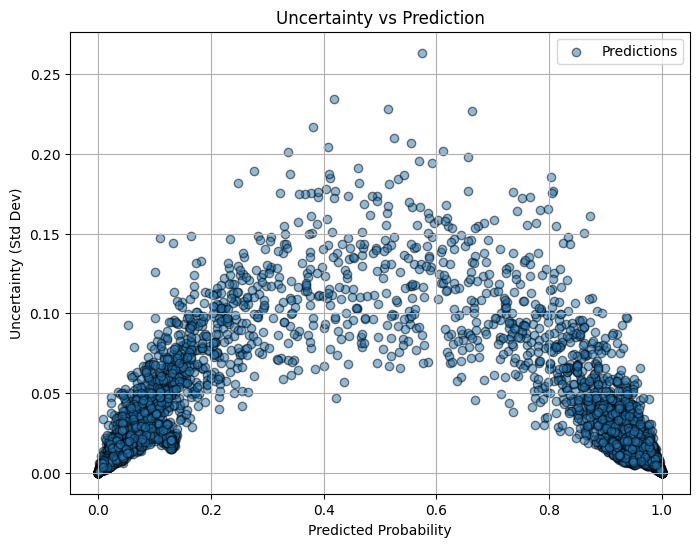

 67%|██████▋   | 2/3 [00:56<00:31, 31.26s/it]

Epoch 1, Train Loss: 0.6988
Epoch 2, Train Loss: 0.6963
Epoch 3, Train Loss: 0.6976
Epoch 4, Train Loss: 0.6952
Epoch 5, Train Loss: 0.6932
Epoch 6, Train Loss: 0.6949
Epoch 7, Train Loss: 0.6943
Epoch 8, Train Loss: 0.6951
Epoch 9, Train Loss: 0.6940
Epoch 10, Train Loss: 0.6942
Epoch 11, Train Loss: 0.6930
Epoch 12, Train Loss: 0.6940
Epoch 13, Train Loss: 0.6937
Epoch 14, Train Loss: 0.6932
Epoch 15, Train Loss: 0.6925
Epoch 16, Train Loss: 0.6933
Epoch 17, Train Loss: 0.6933
Epoch 18, Train Loss: 0.6936
Epoch 19, Train Loss: 0.6932
Epoch 20, Train Loss: 0.6926
Epoch 21, Train Loss: 0.6927
Epoch 22, Train Loss: 0.6931
Epoch 23, Train Loss: 0.6923
Epoch 24, Train Loss: 0.6927
Epoch 25, Train Loss: 0.6924
Epoch 26, Train Loss: 0.6921
Epoch 27, Train Loss: 0.6925
Epoch 28, Train Loss: 0.6922
Epoch 29, Train Loss: 0.6917
Epoch 30, Train Loss: 0.6920
Epoch 31, Train Loss: 0.6919
Epoch 32, Train Loss: 0.6922
Epoch 33, Train Loss: 0.6911
Epoch 34, Train Loss: 0.6917
Epoch 35, Train Loss: 0

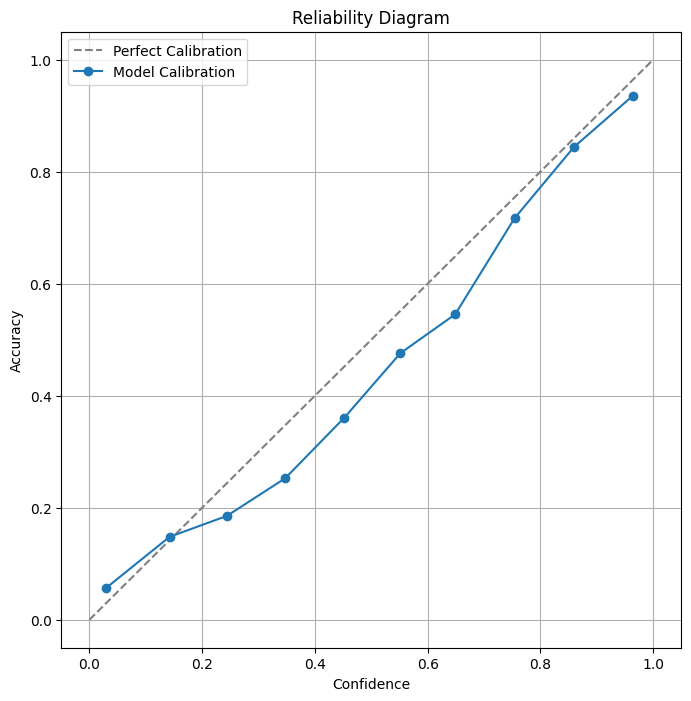

Plotting Uncertainty...


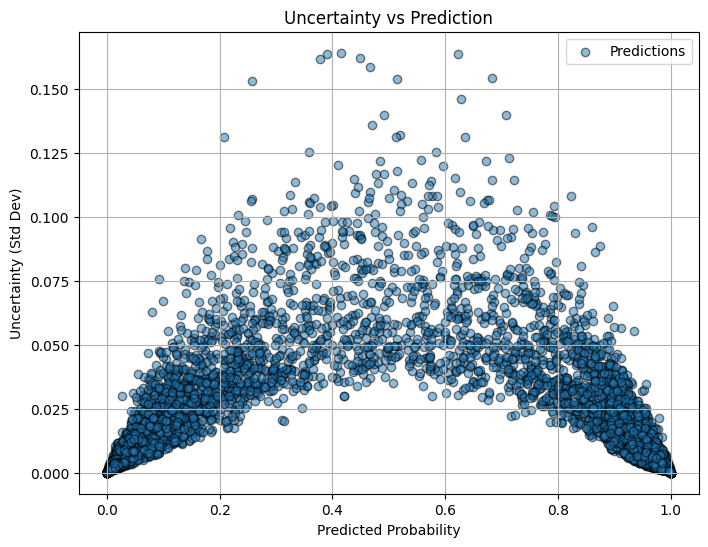

100%|██████████| 3/3 [02:22<00:00, 47.39s/it]

Accuracies across different n values: [(9, 0.9585185185185185), (12, 0.9326388888888889), (15, 0.8865555555555555)]


In [12]:
# Run for each n value and collect accuracies
results = []

hyper_params12 = {
    'optimizer': 'Adam',
    'learning_rate': 0.0022225448311552795,
    'batch_size': 107,
    'layer1_units': 32,
    'layer2_units': 64,
    'prior_mu': 0.0,
    'prior_sigma': 0.027841970984157735,
    'epochs': 164
}

hyper_params9 = {
    'optimizer': 'RAdam',
    'learning_rate': 0.01,
    'batch_size': 203,
    'layer1_units': 128,
    'layer2_units': 64,
    'layer3_units': 64,
    'prior_mu': 0.0,
    'prior_sigma': 0.1,
    'epochs': 50
}


hyper_params15 = {
    'optimizer': 'RAdam',
    'learning_rate': 0.002125965027963112,
    'batch_size': 85,
    'layer1_units': 32,
    'layer2_units': 16,
    'prior_mu': 0.0,
    'prior_sigma': 0.5,
    'epochs': 200
}




hyper_params_dict = {
    9: hyper_params9,
    12: hyper_params12,
    15: hyper_params15,
}


possible_n_vals = [9, 12, 15]
for n in tqdm(possible_n_vals):
    hyper_params = hyper_params_dict[n]
    accuracy = run_bayesian_nn_plot(n, hyper_params)
    results.append((n, accuracy))

print("Accuracies across different n values:", results)

# Threshold grid for each n value
thresh_grid = {
    '9': 0.95,  
    '12': 0.925,
    '15': 0.90,
    '18': 0.875,
    '24': 0.80,
    '30': 0.75,
    '45': 0.70
}


In [11]:
space = [
    Categorical(['Adam', 'AdamW', 'RAdam'], name='optimizer'),
    Real(1e-6, 1e-1, prior='log-uniform', name='learning_rate'),
    Integer(32, 128, name='batch_size'),
    Integer(32, 128, name='layer1_units'),
    Integer(16, 64, name='layer2_units'),
    Real(0.0, 1.0, name='prior_mu'),
    Real(0.01, 0.5, name='prior_sigma'),
    Integer(10, 200, name='epochs')
]



# Objective function to optimize using Gaussian Process
@use_named_args(space)
def objective_function(optimizer, learning_rate, batch_size, layer1_units, layer2_units, prior_mu, prior_sigma, epochs, n=12):
    # Load the data for the specific dataset
    X = np.load(f'Datasets/kryptonite-{n}-X.npy')
    y = np.load(f'Datasets/kryptonite-{n}-y.npy')
    
    # Split the dataset into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
    X_val, _, y_val, _ = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Convert to torch tensors and create DataLoader instances
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

    batch_size = int(max(16, batch_size))
    # DataLoader for training and validation
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

    # Initialize the model with the given hyperparameters
    model = BayesianNN(input_dim=X_train.shape[1], 
                       prior_mu=prior_mu, prior_sigma=prior_sigma, 
                       layer1_units=layer1_units, layer2_units=layer2_units)
    
    criterion = nn.BCELoss()  # Binary Cross-Entropy loss
    if optimizer == 'Adam':
        opt = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'AdamW':
        opt = optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer == 'RAdam':
        opt = optim.RAdam(model.parameters(), lr=learning_rate)
    
    
    # Training the model for a fixed number of epochs
    for epoch in range(epochs):  # Use 10 epochs for each optimization trial
        train_bayesian_nn(model, train_loader, criterion, opt)
    
    # Evaluate the model on the validation set
    y_val_pred = evaluate_bayesian_nn(model, val_loader)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Return the negative validation accuracy to minimize (since gp_minimize tries to minimize the objective)
    return -val_accuracy



# Run Bayesian Optimization with Gaussian Process
results = gp_minimize(objective_function, space, n_calls=50, random_state=42, verbose=True)

# Print the best found hyperparameters
print("Best hyperparameters found:")
for param, value in zip(space, results.x):
    print(f"{param.name}: {value}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 16.9363
Function value obtained: -0.5046
Current minimum: -0.5046
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 65.4281
Function value obtained: -0.9318
Current minimum: -0.9318
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 28.9592
Function value obtained: -0.5038
Current minimum: -0.9318
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 28.5951
Function value obtained: -0.7863
Current minimum: -0.9318
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 27.1885
Function value obtained: -0.5079
Current minimum: -0.9318
Iteration No: 6 star